In [ ]:
# Cell 1: Imports and Configuration
import torch
import os
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from PIL import Image
from transformers import (
    AutoProcessor,
    AutoModel,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, get_peft_model
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import requests
from io import BytesIO
from tqdm import tqdm
import pickle
from pathlib import Path

# Configuration
CONFIG = {
    'MODEL_ID': "google/siglip-base-patch16-224",
    'OUTPUT_DIR': "./siglip-scin-full-3000", # ./siglip-scin-lora",
    'DATA_DIR': "./data/scin_cache",  # Local cache directory
    'BATCH_SIZE': 16,
    'LEARNING_RATE': 5e-5, # 1e-4 before
    'LORA_RANK': 32,
    'LORA_ALPHA': 32,
    'MAX_STEPS': 3000,
    'LOSS_TYPE': "sigmoid",  # or "contrastive"
    'N_VAL_SAMPLES': 1000,
    'N_TRAIN_SAMPLES': 5000,  # Set to None to use all available
}

# Create directories
os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)
os.makedirs(CONFIG['DATA_DIR'], exist_ok=True)

# Device setup
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
print(f"Configuration: {CONFIG}")

In [5]:
from torch.utils.data import Dataset
import pandas as pd

class SyntheticDataset(Dataset):
    """
    A PyTorch Dataset class to load the synthetic data 
    we just saved to disk.
    """
    def __init__(self, metadata_file, img_dir):
        print(f"Loading metadata from: {metadata_file}")
        # Load the CSV file
        self.metadata = pd.read_csv(metadata_file)
        self.img_dir = img_dir
        print(f"Found {len(self.metadata)} images.")

    def __len__(self):
        # Return the total number of samples
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get the filename and label for the given index
        row = self.metadata.iloc[idx]
        filename = row['image_file']
        label = row['label']
        
        # Construct the full image path
        img_path = os.path.join(self.img_dir, filename)
        
        try:
            # Open the image, convert to RGB
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}, returning None. Error: {e}")
            return None
        
        # Return in the same format as your original dataset
        return {"image": image, "text": label}

In [7]:
# Cell 2: Data Loading and Caching Functions

def download_and_cache_dataset(n_train=5000, n_val=1000, force_redownload=False):
    """
    Download dataset from HuggingFace and cache locally.
    
    Args:
        n_train: Number of training samples (None for all)
        n_val: Number of validation samples
        force_redownload: Force redownload even if cache exists
    
    Returns:
        tuple: (train_data_list, val_data_list)
    """
    train_cache = Path(CONFIG['DATA_DIR']) / f"train_{n_train}.pkl"
    val_cache = Path(CONFIG['DATA_DIR']) / f"val_{n_val}.pkl"
    
    # Check if train and validation cache exists
    if not force_redownload and train_cache.exists() and val_cache.exists():
        print(f"Loading cached dataset from {CONFIG['DATA_DIR']}")
        with open(train_cache, 'rb') as f:
            train_data = pickle.load(f)
        with open(val_cache, 'rb') as f:
            val_data = pickle.load(f)
        print(f"Loaded {len(train_data)} training samples and {len(val_data)} validation samples from cache")
        return train_data, val_data
    
    # Download from HuggingFace
    print("Downloading dataset from HuggingFace...")
    try:
        base_iterable = load_dataset("google/scin", split="train", streaming=True)
    except Exception as e:
        print(f"Failed to load dataset. Error: {e}")
        print("Please ensure you have an internet connection and have accepted 'google/scin' terms if any.")
        raise
    
    image_columns = ["image_1_path", "image_2_path", "image_3_path"]
    
    # Load validation data
    print(f"Loading {n_val} validation samples...")
    val_data = []
    for item in tqdm(base_iterable.take(n_val), total=n_val, desc="Loading val samples"):
        text = item.get("related_category")
        if not text or not isinstance(text, str):
            continue
        
        for img_col in image_columns:
            image = item.get(img_col)
            if image and isinstance(image, Image.Image):
                try:
                    val_data.append({"image": image.convert("RGB"), "text": text})
                    break
                except Exception as e:
                    print(f"Error converting image, skipping: {e}")
                    break
    
    # Load training data
    train_iterable = base_iterable.skip(n_val)
    print(f"Loading training samples (max: {n_train if n_train else 'all'})...")
    train_data = []
    
    if n_train:
        iterator = tqdm(train_iterable.take(n_train), total=n_train, desc="Loading train samples")
    else:
        iterator = tqdm(train_iterable, desc="Loading train samples")
    
    for item in iterator:
        text = item.get("related_category")
        if not text or not isinstance(text, str):
            continue
        
        for img_col in image_columns:
            image = item.get(img_col)
            if image and isinstance(image, Image.Image):
                try:
                    train_data.append({"image": image.convert("RGB"), "text": text})
                    break
                except Exception as e:
                    print(f"Error converting image, skipping: {e}")
                    break
        
        if n_train and len(train_data) >= n_train:
            break
    
    # Save to cache
    print(f"Saving {len(train_data)} training samples to cache...")
    with open(train_cache, 'wb') as f:
        pickle.dump(train_data, f)
    
    print(f"Saving {len(val_data)} validation samples to cache...")
    with open(val_cache, 'wb') as f:
        pickle.dump(val_data, f)
    
    print(f"Dataset cached to {CONFIG['DATA_DIR']}")
    return train_data, val_data


def clear_cache():
    """Clear all cached dataset files."""
    cache_dir = Path(CONFIG['DATA_DIR'])
    if cache_dir.exists():
        for file in cache_dir.glob("*.pkl"):
            file.unlink()
            print(f"Deleted {file}")
        print("Cache cleared")
    else:
        print("No cache to clear")


# 1. Load or download google/scin dataset
train_data, val_data = download_and_cache_dataset(
    n_train=CONFIG['N_TRAIN_SAMPLES'],
    n_val=CONFIG['N_VAL_SAMPLES'],
    force_redownload=False  # Set to True to force redownload
)


Loading cached dataset from ./data/scin_cache


: 

In [ ]:

OUTPUT_SYNTHETIC_DIR = "./data/synthetic"
IMG_DIR = os.path.join(OUTPUT_SYNTHETIC_DIR, "images")
METADATA_FILE = os.path.join(OUTPUT_SYNTHETIC_DIR, "labels.csv")

# 2. Load synthetic dataset
synthetic_dataset = SyntheticDataset(
    metadata_file=METADATA_FILE, 
    img_dir=IMG_DIR
)

# 3. Combine them
# from torch.utils.data import ConcatDataset
train_data = ConcatDataset([train_data, synthetic_dataset])

print(f"\nDataset loaded: {len(train_data)} train, {len(val_data)} val samples")

In [3]:
# Cell 3: Dataset Classes

class SCIN_Dataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for SCIN data.
    Works with pre-loaded data lists (from cache or download).
    """
    def __init__(self, data_list):
        print(f"Initializing SCIN_Dataset with {len(data_list)} samples.")
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def collate_fn(batch, processor):
    """
    Data collator with robust error handling.
    """
    processed_images = []
    processed_texts_input_ids = []
    skipped_count = 0

    for i, item in enumerate(batch):
        try:
            if item is None:
                skipped_count += 1
                continue

            img = item.get("image")
            raw_txt = item.get("text")
            txt = f"This is a photo of {raw_txt}"  # <-- Use a prompt template

            # Check for invalid content
            if img is None:
                skipped_count += 1
                continue
            if txt is None or txt.strip() == "":
                skipped_count += 1
                continue

            # Process valid items
            inputs = processor(
                text=[txt],
                images=[img],
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=64
            )

            processed_images.append(inputs["pixel_values"])
            processed_texts_input_ids.append(inputs["input_ids"])

        except Exception as e:
            print(f"WARNING (collate_fn): Skipping item {i} due to error: {e}")
            skipped_count += 1

    if not processed_images:
        if len(batch) > 0:
            print(f"ERROR: Entire batch was skipped! ({skipped_count} items failed)")
        return {}

    try:
        batch_pixel_values = torch.cat(processed_images, dim=0)
        batch_input_ids = torch.cat(processed_texts_input_ids, dim=0)

        return {
            "pixel_values": batch_pixel_values,
            "input_ids": batch_input_ids
        }

    except Exception as e:
        print(f"Error during final batch collation: {e}")
        return {}


# Create datasets
train_dataset = SCIN_Dataset(train_data)
val_dataset = SCIN_Dataset(val_data)

print(f"Datasets created: {len(train_dataset)} train, {len(val_dataset)} val")

Initializing SCIN_Dataset with 3032 samples.
Initializing SCIN_Dataset with 747 samples.
Datasets created: 3032 train, 747 val


In [5]:
# Cell 4: Model Loading

def load_models_and_processor(model_id, device):
    """
    Load processor and two model instances (base and tunable).
    
    Returns:
        tuple: (processor, base_model, model_to_tune)
    """
    print(f"Loading processor and models from: {model_id}")
    
    processor = AutoProcessor.from_pretrained(model_id)
    # Uncomment for LoRA
    # dtype = torch.float16 if device == "cuda" else torch.float32
    
    dtype = torch.float32
    print ("dtype - :", dtype)
    
    # Base model (for baseline evaluation)
    base_model = AutoModel.from_pretrained(
        model_id,
        torch_dtype=dtype
    ).to(device)
    
    # Model to fine-tune
    model_to_tune = AutoModel.from_pretrained(
        model_id,
        torch_dtype=dtype
    )
    
    print("Models and processor loaded successfully")
    return processor, base_model, model_to_tune


def apply_lora(model, rank=16, alpha=16):
    """
    Apply LoRA configuration to a model.
    
    Args:
        model: Base model
        rank: LoRA rank
        alpha: LoRA alpha
    
    Returns:
        Model with LoRA applied
    """
    print(f"Applying LoRA configuration (rank={rank}, alpha={alpha})...")
    
    lora_config = LoraConfig(
        r=rank,
        lora_alpha=alpha,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.1,
        bias="none",
    )
    
    model = get_peft_model(model, lora_config)
    
    print("LoRA applied. Trainable parameters:")
    model.print_trainable_parameters()
    
    return model


# Load models
processor, base_model, model_to_tune = load_models_and_processor(
    CONFIG['MODEL_ID'], 
    device
)

# Apply LoRA to the tunable model
# model_to_tune = apply_lora(
#     model_to_tune,
#     rank=CONFIG['LORA_RANK'],
#     alpha=CONFIG['LORA_ALPHA']
# )
model_to_tune = model_to_tune.to(device)

print(f"\nModels ready on device: {device}")

Loading processor and models from: google/siglip-base-patch16-224
dtype - : torch.float32
Models and processor loaded successfully

Models ready on device: cuda


In [6]:
# Cell 5: Metrics and Loss Functions

def compute_metrics(eval_pred):
    """
    Calculate evaluation metrics.
    """
    # Debug: Check what we received
    print(f"\n[compute_metrics] Called with predictions type: {type(eval_pred.predictions)}")
    
    if eval_pred.predictions is None:
        print("[compute_metrics] ERROR: predictions is None!")
        return {
            "accuracy": 0.0,
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
        }
    
    logits = eval_pred.predictions
    print(f"[compute_metrics] Predictions shape: {logits.shape}")
    print(f"[compute_metrics] Predictions range: [{logits.min():.4f}, {logits.max():.4f}]")
    
    # For contrastive learning, each sample should match itself
    # So we predict which position in the batch is the correct match
    predictions = np.argmax(logits, axis=1)
    true_labels = eval_pred.label_ids
    
    print(f"[compute_metrics] Predicted labels (first 10): {predictions[:10]}")
    print(f"[compute_metrics] True labels (first 10): {true_labels[:10]}")
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    acc = accuracy_score(true_labels, predictions)
    
    print(f"[compute_metrics] Computed: acc={acc:.4f}, prec={precision:.4f}, rec={recall:.4f}, f1={f1:.4f}")
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


def compute_loss_function(logits_per_image, logits_per_text, loss_type="sigmoid", device="cpu"):
    """
    Compute loss based on loss type.
    
    Args:
        logits_per_image: Image logits
        logits_per_text: Text logits
        loss_type: "contrastive" or "sigmoid"
        device: Device for computation
    
    Returns:
        Combined loss
    """
    batch_size = logits_per_image.shape[0]
    
    if batch_size <= 1:
        return torch.tensor(0.0, device=device, requires_grad=True)
    
    if loss_type == "contrastive":
        labels = torch.arange(batch_size, device=device)
        loss_images = F.cross_entropy(logits_per_image, labels)
        loss_text = F.cross_entropy(logits_per_text, labels)
        loss = (loss_images + loss_text) / 2.0
    elif loss_type == "sigmoid":
        labels = torch.eye(batch_size, device=device)
        loss_images = F.binary_cross_entropy_with_logits(logits_per_image, labels)
        loss_text = F.binary_cross_entropy_with_logits(logits_per_text, labels)
        loss = (loss_images + loss_text) / 2.0
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")
    
    return loss


print("Metrics and loss functions defined")

Metrics and loss functions defined


In [7]:
# Cell 6: Custom Trainer Class

class CustomTrainer(Trainer):
    """
    Custom Trainer with:
    1. Switchable loss (Contrastive or Sigmoid)
    2. Gradient accumulation for heatmap
    3. Proper evaluation with loss and metrics
    """
    def __init__(self, *args, loss_type="contrastive", **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_type = loss_type
        print(f"CustomTrainer initialized with loss_type: {self.loss_type}")
        
        # Gradient tracking for heatmap
        self.gradient_accumulator = defaultdict(float)
        self.step_count = 0
        
        # Batch stats
        self.successful_batches = 0
        self.skipped_batches_eval = 0

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Training loss computation."""
        if not inputs or "pixel_values" not in inputs:
            dummy_loss = torch.tensor(0.0, device=model.device, requires_grad=True)
            return (dummy_loss, {}) if return_outputs else dummy_loss

        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        
        loss = compute_loss_function(
            logits_per_image,
            logits_per_text,
            loss_type=self.loss_type,
            device=model.device
        )

        return (loss, outputs) if return_outputs else loss

    def training_step(self, model, inputs, num_items_in_batch):
        """Training step with gradient tracking."""
        loss = super().training_step(model, inputs, num_items_in_batch)

        if loss is not None:
            self.step_count += 1
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None and param.requires_grad:
                        self.gradient_accumulator[name] += param.grad.norm().item()
        return loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """Evaluation step with loss computation."""
        if not inputs or "pixel_values" not in inputs:
            self.skipped_batches_eval += 1
            return (None, None, None)
        
        with torch.no_grad():
            outputs = model(**inputs)
            
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text
            batch_size = logits_per_image.shape[0]
            
            # Check for NaN/Inf
            if torch.isnan(logits_per_image).any() or torch.isinf(logits_per_image).any():
                print("WARNING: NaN or Inf detected in logits during eval.")
                self.skipped_batches_eval += 1
                return (None, None, None)
            
            # Compute loss
            loss = None
            if batch_size <= 1:
                self.skipped_batches_eval += 1
            else:
                loss = compute_loss_function(
                    logits_per_image,
                    logits_per_text,
                    loss_type=self.loss_type,
                    device=model.device
                )
                self.successful_batches += 1
        
        predictions = logits_per_image.cpu()
        # Create a dummy label tensor of the same batch size
        # compute_metrics function seeing the label as 'None' skips calling compute_metrics. 
        # It completely ignores the dummy_labels it's handed. Instead, it just creates its 
        # own correct labels inside the function: true_labels = np.arange(len(predictions))
        dummy_labels = torch.arange(predictions.shape[0], device=predictions.device)
        return (loss, predictions, dummy_labels)

    def _extract_layer_index(self, name_parts):
        """Extract layer index from parameter name."""
        for part in name_parts:
            if part.isdigit():
                return int(part)
        return None

    def _extract_component_name(self, name_parts):
        """Extract component name from parameter name."""
        name_str = ".".join(name_parts)
        if "lora_A" in name_str:
            if "q_proj" in name_str: return "LoRA A (Query)"
            if "v_proj" in name_str: return "LoRA A (Value)"
        elif "lora_B" in name_str:
            if "q_proj" in name_str: return "LoRA B (Query)"
            if "v_proj" in name_str: return "LoRA B (Value)"
        if "q_proj" in name_str: return "Query Proj"
        if "v_proj" in name_str: return "Value Proj"
        if "k_proj" in name_str: return "Key Proj"
        if "fc1" in name_str: return "MLP Layer 1"
        if "fc2" in name_str: return "MLP Layer 2"
        return None

    def _process_gradients_for_heatmap(self):
        """Process accumulated gradients for heatmap generation."""
        if self.step_count == 0:
            print("No training steps recorded. Skipping heatmap.")
            return None, None, []

        vision_data = defaultdict(lambda: defaultdict(float))
        text_data = defaultdict(lambda: defaultdict(float))
        skipped_params = []

        for name, avg_grad_norm in self.gradient_accumulator.items():
            avg_norm = avg_grad_norm / self.step_count
            parts = name.split('.')
            layer_idx = self._extract_layer_index(parts)
            component = self._extract_component_name(parts)
            
            if layer_idx is None or component is None:
                if "lora_" in name:
                    skipped_params.append(name)
                continue
            
            if "vision_model" in name:
                vision_data[layer_idx][component] = avg_norm
            elif "text_model" in name:
                text_data[layer_idx][component] = avg_norm
            else:
                if "lora_" in name:
                    skipped_params.append(name)

        vision_df = pd.DataFrame.from_dict(vision_data, orient='index').sort_index()
        text_df = pd.DataFrame.from_dict(text_data, orient='index').sort_index()
        return vision_df, text_df, skipped_params

    def plot_final_heatmap(self, save_path):
        """Generate and save gradient impact heatmap."""
        print("\nGenerating final gradient heatmaps...")
        vision_df, text_df, skipped = self._process_gradients_for_heatmap()
        
        if vision_df is None or (vision_df.empty and text_df.empty):
            print("No gradient data collected. Skipping heatmap file.")
            return
        
        if skipped:
            print(f"[WARN] Skipped {len(skipped)} LoRA params (couldn't parse name)")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        vmin = 0.0
        vmax = max(
            vision_df.max().max() if not vision_df.empty else 0,
            text_df.max().max() if not text_df.empty else 0
        )
        if vmax == 0:
            vmax = 1.0

        if not vision_df.empty:
            sns.heatmap(vision_df, ax=ax1, cmap="magma", annot=True, fmt=".2e",
                        linewidths=.5, vmin=vmin, vmax=vmax)
            ax1.set_title("Vision Encoder Impact (Avg. Gradient Norm)", fontsize=16)
            ax1.set_ylabel("Layer Depth", fontsize=12)
            ax1.set_xlabel("Transformer Component (LoRA)", fontsize=12)
        else:
            ax1.text(0.5, 0.5, "No Vision Gradients Found", ha='center', va='center')
            ax1.set_title("Vision Encoder Impact", fontsize=16)

        if not text_df.empty:
            sns.heatmap(text_df, ax=ax2, cmap="magma", annot=True, fmt=".2e",
                        linewidths=.5, vmin=vmin, vmax=vmax)
            ax2.set_title("Text Encoder Impact (Avg. Gradient Norm)", fontsize=16)
            ax2.set_ylabel("Layer Depth", fontsize=12)
            ax2.set_xlabel("Transformer Component (LoRA)", fontsize=12)
        else:
            ax2.text(0.5, 0.5, "No Text Gradients Found", ha='center', va='center')
            ax2.set_title("Text Encoder Impact", fontsize=16)

        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        print(f"Heatmap saved to: {save_path}")


print("CustomTrainer class defined")

CustomTrainer class defined


In [8]:
# Cell 7: Training Setup
def create_training_args(config, device, debug_mode=False):
    """
    Create training arguments.
    
    Args:
        config: Configuration dictionary
        device: Device string
        debug_mode: If True, use minimal steps for quick testing
    
    Returns:
        TrainingArguments
    """
    # For LoRA
    # use_fp16 = True if device == "cuda" else False
    
    #For full model traing
    use_fp16 = False
    
    if debug_mode:
        print("Creating DEBUG training arguments (quick run)...")
        args = TrainingArguments(
            output_dir=config['OUTPUT_DIR'],
            per_device_train_batch_size=config['BATCH_SIZE'],
            per_device_eval_batch_size=config['BATCH_SIZE'],
            max_steps=2,
            eval_strategy="steps",  # THIS IS THE FIX
            eval_steps=1,
            logging_steps=1,
            warmup_steps=1,
            weight_decay=0.01,
            learning_rate=config['LEARNING_RATE'],
            save_strategy="no",
            load_best_model_at_end=False,
            fp16=use_fp16,
            report_to="none",
            remove_unused_columns=False,
            prediction_loss_only=False,
        )
    else:
        print("Creating FULL training arguments...")
        args = TrainingArguments(
            output_dir=config['OUTPUT_DIR'],
            per_device_train_batch_size=config['BATCH_SIZE'],
            per_device_eval_batch_size=config['BATCH_SIZE'],
            max_steps=config['MAX_STEPS'],
            weight_decay=0.01,
            learning_rate=config['LEARNING_RATE'],
            warmup_steps=50,
            logging_steps=50,
            save_strategy="steps",
            save_steps=250,
            eval_strategy="steps",
            eval_steps=250,
            load_best_model_at_end=False,
            fp16=use_fp16,
            report_to="none",
            remove_unused_columns=False,
            prediction_loss_only=False,
        )
    
    return args


# Create training arguments
# Set debug_mode=True for quick testing, False for full training
training_args = create_training_args(CONFIG, device, debug_mode=False)

# Initialize trainer
trainer = CustomTrainer(
    model=model_to_tune,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: collate_fn(data, processor),
    loss_type=CONFIG['LOSS_TYPE'],
    compute_metrics=compute_metrics
)

print("Trainer initialized and ready")
print(f"Loss type: {CONFIG['LOSS_TYPE']}")
print(f"Training steps: {training_args.max_steps}")

Creating FULL training arguments...
CustomTrainer initialized with loss_type: sigmoid
Trainer initialized and ready
Loss type: sigmoid
Training steps: 3000


In [9]:
# Cell 8: Run Baseline Evaluation

print("="*60)
print("RUNNING BASELINE EVALUATION (BEFORE FINE-TUNING)")
print("="*60)

# Use the Trainer's standard evaluate() method
# We temporarily swap in the base_model to evaluate it
trainer.model = base_model
baseline_metrics = trainer.evaluate()
trainer.model = model_to_tune # Swap back to the model we're training

print("\nBaseline Evaluation Metrics:")
print(baseline_metrics) # This will now have all metrics

print("\nBaseline evaluation complete. Ready for fine-tuning.")

RUNNING BASELINE EVALUATION (BEFORE FINE-TUNING)



[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, 3.7119]
[compute_metrics] Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0683, prec=0.0826, rec=0.0678, f1=0.0277

Baseline Evaluation Metrics:
{'eval_loss': 0.6896528005599976, 'eval_model_preparation_time': 0.0059, 'eval_accuracy': 0.06827309236947791, 'eval_precision': 0.08259853679248724, 'eval_recall': 0.06784805735430156, 'eval_f1': 0.02767441441809072, 'eval_runtime': 7.5141, 'eval_samples_per_second': 99.414, 'eval_steps_per_second': 6.255}

Baseline evaluation complete. Ready for fine-tuning.


In [10]:
# Cell 9: Run Fine-Tuning

print("="*60)
print("STARTING FINE-TUNING")
print("="*60)

# Train the model
trainer.train()

print("\n" + "="*60)
print("FINE-TUNING COMPLETE")
print("="*60)

STARTING FINE-TUNING


Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
250,0.233700,0.235132,0.005900,0.061580,0.051189,0.061286,0.036509
500,0.233600,0.234904,0.005900,0.072289,0.084168,0.071982,0.055201
750,0.233600,0.234694,0.005900,0.074967,0.114154,0.074613,0.048787
1000,0.232000,0.235882,0.005900,0.074967,0.150178,0.074526,0.052313
1250,0.230800,0.235871,0.005900,0.070950,0.074218,0.070623,0.059005
1500,0.226300,0.238573,0.005900,0.066934,0.046429,0.066547,0.039805
1750,0.214900,0.263120,0.005900,0.066934,0.062186,0.066576,0.035920
2000,0.207000,0.273752,0.005900,0.056225,0.033341,0.055938,0.028684
2250,0.199900,0.288635,0.005900,0.062918,0.044342,0.062587,0.032316
2500,0.194500,0.304179,0.005900,0.057564,0.039713,0.057296,0.029653



[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, -2.5898]
[compute_metrics] Predicted labels (first 10): [9 0 0 0 0 0 0 0 9 0]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0616, prec=0.0512, rec=0.0613, f1=0.0365

[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, 0.2902]
[compute_metrics] Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0723, prec=0.0842, rec=0.0720, f1=0.0552

[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, -1.9461]
[compute_metrics] Predicted labels (first 10): [0 0

In [11]:
# Cell 10: Run Final Evaluation

print("="*60)
print("RUNNING FINAL EVALUATION (AFTER FINE-TUNING)")
print("="*60)

# Use the Trainer's standard evaluate() method
final_metrics = trainer.evaluate()

print("\nFinal Evaluation Metrics:")
print(final_metrics) # This will also have all metrics

# --- Keep the comparison logic ---
print("\n" + "="*60)
print("COMPARISON: BASELINE vs FINE-TUNED")
print("="*60)

comparison_keys = ['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']
print(f"{'Metric':<25} {'Baseline':<12} {'Fine-Tuned':<12} {'Change':<12}")
print("-" * 65)

for key in comparison_keys:
    if key in baseline_metrics and key in final_metrics:
        baseline_val = baseline_metrics.get(key)
        final_val = final_metrics.get(key)
        
        if baseline_val is not None and final_val is not None:
            change = final_val - baseline_val
            change_str = f"{change:+.4f}"
            
            if key != 'eval_loss':  # Higher is better
                indicator = "📈" if change > 0 else "📉" if change < 0 else "➡️"
            else:  # Lower is better for loss
                indicator = "📉" if change < 0 else "📈" if change > 0 else "➡️"
            
            print(f"{key:<25} {baseline_val:<12.4f} {final_val:<12.4f} {change_str:<12} {indicator}")
        else:
            print(f"{key:<25} {'N/A':<12} {'N/A':<12} {'N/A':<12}")
    else:
        print(f"{key:<25} {'N/A':<12} {'N/A':<12} {'N/A':<12}")

RUNNING FINAL EVALUATION (AFTER FINE-TUNING)



[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, -0.0501]
[compute_metrics] Predicted labels (first 10): [9 0 0 0 0 0 0 0 0 0]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0576, prec=0.0399, rec=0.0573, f1=0.0277

Final Evaluation Metrics:
{'eval_loss': 0.32775330543518066, 'eval_model_preparation_time': 0.0059, 'eval_accuracy': 0.05756358768406961, 'eval_precision': 0.039921142069419345, 'eval_recall': 0.05726757631822387, 'eval_f1': 0.027718999483170338, 'eval_runtime': 6.7632, 'eval_samples_per_second': 110.45, 'eval_steps_per_second': 6.949, 'epoch': 15.789473684210526}

COMPARISON: BASELINE vs FINE-TUNED
Metric                    Baseline     Fine-Tuned   Change      
-----------------------------------------------------------------
eval_loss                 0.6897       0.3278       -0.3619      📉
eval_accurac

In [12]:
# Cell 11: Save Model and Generate Heatmap

print("="*60)
print("SAVING MODEL AND GENERATING VISUALIZATIONS")
print("="*60)

# Save LoRA adapter
final_adapter_path = os.path.join(CONFIG['OUTPUT_DIR'], "final-adapter")
model_to_tune.save_pretrained(final_adapter_path)
processor.save_pretrained(final_adapter_path)
print(f"\nLoRA adapter saved to: {final_adapter_path}")

# Generate and save heatmap
heatmap_path = os.path.join(CONFIG['OUTPUT_DIR'], "gradient_impact_heatmap.png")
trainer.plot_final_heatmap(save_path=heatmap_path)

print("\nModel and visualizations saved successfully!")

SAVING MODEL AND GENERATING VISUALIZATIONS

LoRA adapter saved to: ./siglip-scin-full-3000/final-adapter

Generating final gradient heatmaps...
Heatmap saved to: ./siglip-scin-full-3000/gradient_impact_heatmap.png

Model and visualizations saved successfully!


In [13]:
# Cell 12: Qualitative Analysis Functions

def get_similarity_scores(model, processor, image, text_probes, device):
    """
    Get model similarity scores for an image and text probes.
    
    Args:
        model: Model to evaluate
        processor: Processor for inputs
        image: PIL Image
        text_probes: List of text strings
        device: Device string
    
    Returns:
        numpy array of similarity scores
    """
    inputs = processor(
        text=text_probes,
        images=[image],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=64
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.sigmoid(outputs.logits_per_image).cpu().numpy().flatten()
    return scores


def plot_similarity_scores(base_scores, tuned_scores, probes, true_category, save_path):
    """
    Generate bar chart comparing baseline and fine-tuned similarity scores.
    
    Args:
        base_scores: Baseline model scores
        tuned_scores: Fine-tuned model scores
        probes: List of text probes
        true_category: The correct category
        save_path: Path to save plot
    """
    df_data = {
        "Text Probe": probes * 2,
        "Similarity Score": np.concatenate([base_scores, tuned_scores]),
        "Model": ["Baseline"] * len(probes) + ["Fine-Tuned"] * len(probes)
    }
    df = pd.DataFrame(df_data)

    plt.figure(figsize=(15, 7))
    sns.barplot(
        data=df,
        x="Text Probe",
        y="Similarity Score",
        hue="Model",
        palette={"Baseline": "lightblue", "Fine-Tuned": "darkblue"}
    )

    # Highlight correct category
    ax = plt.gca()
    for i, probe in enumerate(probes):
        if probe == true_category:
            ax.get_xticklabels()[i].set_color("red")
            ax.get_xticklabels()[i].set_fontweight("bold")

    plt.title(f"Qualitative Similarity Test (True Category: {true_category})", fontsize=16)
    plt.ylabel("Similarity Score (Sigmoid)", fontsize=12)
    plt.xlabel("Text Probes", fontsize=12)
    plt.xticks(rotation=15)
    plt.legend(title="Model", fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Similarity plot saved to: {save_path}")


def run_qualitative_test(base_model, tuned_model, processor, device, output_dir, 
                         custom_image=None, custom_category=None, custom_probes=None):
    """
    Run qualitative similarity test on a sample image.
    
    Args:
        base_model: Baseline model
        tuned_model: Fine-tuned model
        processor: Processor
        device: Device string
        output_dir: Directory to save results
        custom_image: Optional PIL Image to test (if None, uses dataset sample)
        custom_category: Optional category label
        custom_probes: Optional list of text probes
    """
    print("\n" + "="*60)
    print("RUNNING QUALITATIVE SIMILARITY TEST")
    print("="*60)
    
    # Default test probes
    if custom_probes is None:
        TEXT_PROBES = [
            "benign keratosis",
            "melanoma", 
            "nevus",
            "eczema",
            "basal cell carcinoma"
        ]
    else:
        TEXT_PROBES = custom_probes
    
    try:
        # Get test image
        if custom_image is not None:
            image = custom_image.convert("RGB") if custom_image.mode != "RGB" else custom_image
            SAMPLE_IMG_CATEGORY = custom_category if custom_category else TEXT_PROBES[0]
            print(f"Using custom image")
        else:
            # Use a sample from the validation dataset
            print("Using sample from validation dataset...")
            sample_idx = 0
            sample = val_data[sample_idx]
            image = sample['image']
            SAMPLE_IMG_CATEGORY = sample['text']
            print(f"Using validation sample {sample_idx}")
        
        print(f"True category: {SAMPLE_IMG_CATEGORY}")
        print(f"Text probes: {TEXT_PROBES}")
        
        # Get scores from both models
        print("\nComputing similarity scores...")
        base_scores = get_similarity_scores(base_model, processor, image, TEXT_PROBES, device)
        tuned_scores = get_similarity_scores(tuned_model, processor, image, TEXT_PROBES, device)
        
        # Print scores
        print("\nSimilarity Scores:")
        print(f"{'Probe':<25} {'Baseline':<12} {'Fine-Tuned':<12} {'Change':<12}")
        print("-" * 60)
        for i, probe in enumerate(TEXT_PROBES):
            change = tuned_scores[i] - base_scores[i]
            marker = " *" if probe == SAMPLE_IMG_CATEGORY else ""
            print(f"{probe:<25} {base_scores[i]:<12.4f} {tuned_scores[i]:<12.4f} {change:+.4f}{marker}")
        
        # Plot and save
        sim_report_path = os.path.join(output_dir, "similarity_report.png")
        plot_similarity_scores(base_scores, tuned_scores, TEXT_PROBES, SAMPLE_IMG_CATEGORY, sim_report_path)
        
        print("\nQualitative test complete!")
        return sim_report_path
        
    except Exception as e:
        print(f"ERROR during qualitative test: {e}")
        return None


print("Qualitative analysis functions defined")

Qualitative analysis functions defined


In [14]:
# Cell 13: Run Qualitative Test

similarity_plot_path = run_qualitative_test(
    base_model=base_model,
    tuned_model=model_to_tune.to(device),
    processor=processor,
    device=device,
    output_dir=CONFIG['OUTPUT_DIR'],
    custom_image=None,  # Uses val_data[0]
    custom_category=None,
    custom_probes=None
)


RUNNING QUALITATIVE SIMILARITY TEST
Using sample from validation dataset...
Using validation sample 0
True category: RASH
Text probes: ['benign keratosis', 'melanoma', 'nevus', 'eczema', 'basal cell carcinoma']

Computing similarity scores...

Similarity Scores:
Probe                     Baseline     Fine-Tuned   Change      
------------------------------------------------------------
benign keratosis          0.0021       0.0044       +0.0024
melanoma                  0.0000       0.0006       +0.0005
nevus                     0.0013       0.0080       +0.0067
eczema                    0.0475       0.0106       -0.0368
basal cell carcinoma      0.0000       0.0016       +0.0016
Similarity plot saved to: ./siglip-scin-full-3000/similarity_report.png

Qualitative test complete!


In [15]:
# Cell 14: Generate Final Report

def generate_final_report(baseline_metrics, final_metrics, output_dir):
    """
    Generate a markdown report with all results.
    
    Args:
        baseline_metrics: Dictionary of baseline metrics
        final_metrics: Dictionary of final metrics
        output_dir: Directory to save report
    """
    print("\n" + "="*60)
    print("GENERATING FINAL REPORT")
    print("="*60)
    
    report_path = os.path.join(output_dir, "final_report.md")
    
    report_content = "# Fine-Tuning Experiment Report\n\n"
    report_content += f"**Model:** {CONFIG['MODEL_ID']}\n"
    report_content += f"**Loss Type:** {CONFIG['LOSS_TYPE']}\n"
    report_content += f"**LoRA Rank:** {CONFIG['LORA_RANK']}\n"
    report_content += f"**LoRA Alpha:** {CONFIG['LORA_ALPHA']}\n"
    report_content += f"**Training Steps:** {CONFIG['MAX_STEPS']}\n"
    report_content += f"**Learning Rate:** {CONFIG['LEARNING_RATE']}\n\n"
    
    # Quantitative metrics
    report_content += "## 1. Quantitative Metrics\n\n"
    report_content += "Comparison of model performance on the validation set before and after fine-tuning.\n\n"
    report_content += "| Metric | Baseline (Before) | Fine-Tuned (After) | Change |\n"
    report_content += "| :--- | :--- | :--- | :--- |\n"
    
    def get_metric(metrics, key, precision=4):
        val = metrics.get(key)
        if val is None:
            return "N/A"
        return f"{val:.{precision}f}"
    
    def get_change(baseline, final, key, precision=4):
        b = baseline.get(key)
        f = final.get(key)
        if b is None or f is None:
            return "N/A"
        change = f - b
        sign = "+" if change >= 0 else ""
        return f"{sign}{change:.{precision}f}"
    
    metric_keys = [
        ("eval_loss", "Eval Loss"),
        ("eval_accuracy", "Accuracy"),
        ("eval_precision", "Precision (Macro)"),
        ("eval_recall", "Recall (Macro)"),
        ("eval_f1", "F1-Score (Macro)"),
        ("eval_runtime", "Eval Runtime (s)"),
    ]
    
    for key, name in metric_keys:
        b_val = get_metric(baseline_metrics, key)
        f_val = get_metric(final_metrics, key)
        c_val = get_change(baseline_metrics, final_metrics, key)
        report_content += f"| **{name}** | {b_val} | {f_val} | {c_val} |\n"
    
    # Qualitative analysis
    report_content += "\n## 2. Qualitative Analysis (Similarity Test)\n\n"
    report_content += "This test shows how the model's understanding of specific concepts changed.\n\n"
    report_content += "![Similarity Plot](similarity_report.png)\n\n"
    report_content += "**Interpretation:** The fine-tuned model should show higher similarity scores for the correct category.\n"
    
    # Gradient heatmap
    report_content += "\n## 3. Gradient Impact Heatmap\n\n"
    report_content += "This heatmap shows which parts of the model were modified most during fine-tuning.\n\n"
    report_content += "![Gradient Impact Heatmap](gradient_impact_heatmap.png)\n\n"
    report_content += "**Interpretation:** Brighter colors indicate layers heavily modified by fine-tuning.\n"
    
    # Save report
    try:
        with open(report_path, "w") as f:
            f.write(report_content)
        print(f"Report saved to: {report_path}")
    except Exception as e:
        print(f"ERROR saving report: {e}")


# Generate the report
generate_final_report(
    baseline_metrics=baseline_metrics,
    final_metrics=final_metrics,
    output_dir=CONFIG['OUTPUT_DIR']
)

print("\n" + "="*60)
print("ALL TASKS COMPLETE!")
print("="*60)
print(f"Results saved to: {CONFIG['OUTPUT_DIR']}")
print("Files generated:")
print("  - final-adapter/ (LoRA weights)")
print("  - gradient_impact_heatmap.png")
print("  - similarity_report.png")
print("  - final_report.md")


GENERATING FINAL REPORT
Report saved to: ./siglip-scin-full-3000/final_report.md

ALL TASKS COMPLETE!
Results saved to: ./siglip-scin-full-3000
Files generated:
  - final-adapter/ (LoRA weights)
  - gradient_impact_heatmap.png
  - similarity_report.png
  - final_report.md



UNDERSTANDING THE METRICS

In contrastive learning with SigLIP, we're training the model so that:
- Each image should have highest similarity with its matching text
- Each text should have highest similarity with its matching image

For a batch of size N:
- We get an NxN similarity matrix (logits_per_image)
- The correct match for sample i is position i (diagonal elements)
- We predict which position has the highest similarity
- Accuracy = how often we predict the correct position

EXAMPLE:
--------
Batch of 16 images with their text descriptions:
- Image 0 with "melanoma" should match Text 0 "melanoma" (position 0)
- Image 1 with "nevus" should match Text 1 "nevus" (position 1)
- etc.

The model outputs a 16x16 similarity matrix. For each row i, we find argmax:
- If argmax(row_0) = 0  ✓ Correct! 
- If argmax(row_1) = 0  ✗ Wrong (should be 1)
- If argmax(row_2) = 2  ✓ Correct!

Accuracy = (number of correct predictions) / 16

INTERPRETING YOUR RESULTS:
--------------------------
Your 

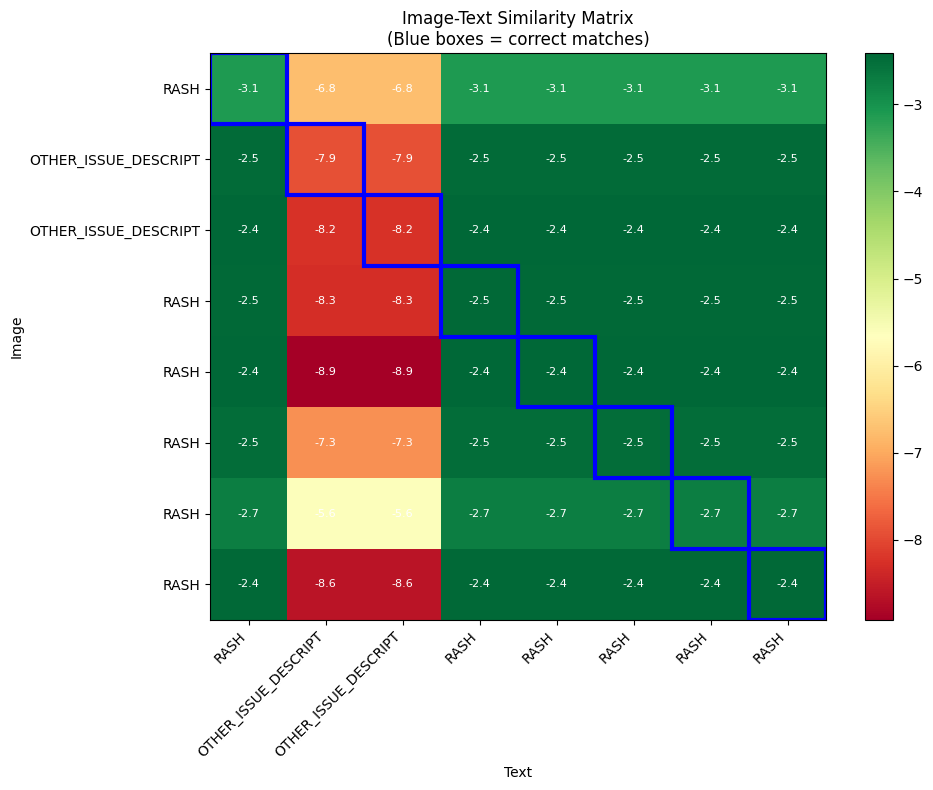


Batch Accuracy: 12.50%
Correct predictions: 1/8

Diagonal values (correct matches): [-3.0992413 -7.905852  -8.234087  -2.4508963 -2.4118185 -2.5124445
 -2.7302237 -2.4454918]
Mean diagonal: -3.97
Mean off-diagonal: -3.83


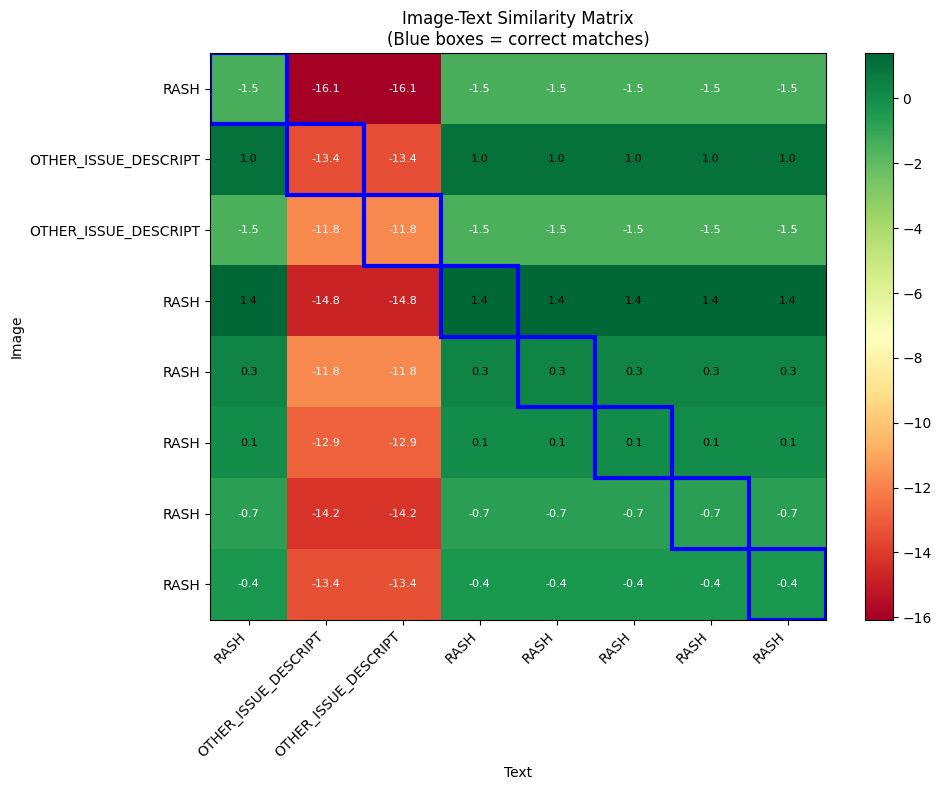


Batch Accuracy: 12.50%
Correct predictions: 1/8

Diagonal values (correct matches): [ -1.4631739  -13.4458885  -11.8106365    1.3966837    0.33795357
   0.0533371   -0.72241306  -0.38426876]
Mean diagonal: -3.25
Mean off-diagonal: -3.54


In [16]:
# CELL: Understanding the Metrics for Contrastive Learning

"""
UNDERSTANDING THE METRICS
=========================

In contrastive learning with SigLIP, we're training the model so that:
- Each image should have highest similarity with its matching text
- Each text should have highest similarity with its matching image

For a batch of size N:
- We get an NxN similarity matrix (logits_per_image)
- The correct match for sample i is position i (diagonal elements)
- We predict which position has the highest similarity
- Accuracy = how often we predict the correct position

EXAMPLE:
--------
Batch of 16 images with their text descriptions:
- Image 0 with "melanoma" should match Text 0 "melanoma" (position 0)
- Image 1 with "nevus" should match Text 1 "nevus" (position 1)
- etc.

The model outputs a 16x16 similarity matrix. For each row i, we find argmax:
- If argmax(row_0) = 0  ✓ Correct! 
- If argmax(row_1) = 0  ✗ Wrong (should be 1)
- If argmax(row_2) = 2  ✓ Correct!

Accuracy = (number of correct predictions) / 16

INTERPRETING YOUR RESULTS:
--------------------------
Your debug showed:
  - Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
  - True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
  - Accuracy: 0.0208 (2.08%)

This means:
⚠️ The model is predicting position 0 for almost everything!
⚠️ This is terrible performance (random would be ~6.25% for batch_size=16)

WHY IS THIS HAPPENING?
----------------------
1. The model hasn't been trained yet (baseline is untrained)
2. Or the model collapsed to predicting the same thing for everything
3. Only 2 training steps in debug mode (way too few!)

WHAT TO EXPECT AFTER TRAINING:
-------------------------------
- Baseline (untrained): 2-10% accuracy (random or worse)
- After training: 40-90% accuracy (depending on dataset difficulty)
- Well-trained: 70%+ accuracy

Good performance means:
✓ Accuracy increases significantly (20-30+ percentage points)
✓ Loss decreases
✓ The model learns to distinguish between different skin conditions
"""

def visualize_similarity_matrix(model, dataset, processor, device, num_samples=8):
    """
    Visualize the similarity matrix for a small batch.
    This helps understand what the model is learning.
    
    Args:
        model: Model to evaluate
        dataset: Dataset to sample from
        processor: Processor
        device: Device
        num_samples: Number of samples to visualize
    """
    import matplotlib.pyplot as plt
    
    # Get a batch
    samples = [dataset[i] for i in range(min(num_samples, len(dataset)))]
    inputs = collate_fn(samples, processor)
    
    if not inputs:
        print("Failed to create batch")
        return
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        similarity_matrix = outputs.logits_per_image.cpu().numpy()
    
    # Get labels
    labels = [s['text'][:20] for s in samples]  # Truncate for display
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(similarity_matrix, cmap='RdYlGn', aspect='auto')
    
    # Add colorbar
    plt.colorbar(im, ax=ax)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    
    # Add values in cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            color = 'white' if similarity_matrix[i, j] < 0 else 'black'
            text = ax.text(j, i, f'{similarity_matrix[i, j]:.1f}',
                          ha="center", va="center", color=color, fontsize=8)
    
    # Highlight diagonal
    for i in range(len(labels)):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, 
                                   fill=False, edgecolor='blue', lw=3))
    
    ax.set_title("Image-Text Similarity Matrix\n(Blue boxes = correct matches)")
    ax.set_xlabel("Text")
    ax.set_ylabel("Image")
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['OUTPUT_DIR'], 'similarity_matrix.png'))
    plt.show()
    
    # Print interpretation
    predictions = np.argmax(similarity_matrix, axis=1)
    correct = predictions == np.arange(len(predictions))
    accuracy = correct.sum() / len(correct)
    
    print(f"\nBatch Accuracy: {accuracy:.2%}")
    print(f"Correct predictions: {correct.sum()}/{len(correct)}")
    print(f"\nDiagonal values (correct matches): {np.diag(similarity_matrix)}")
    print(f"Mean diagonal: {np.diag(similarity_matrix).mean():.2f}")
    print(f"Mean off-diagonal: {similarity_matrix[~np.eye(len(labels), dtype=bool)].mean():.2f}")


print(__doc__)
print("\nVisualization function available:")
# Visualize the model AFTER fine-tuning
visualize_similarity_matrix(model_to_tune, val_dataset, processor, device)

# Visualize the model BEFORE fine-tuning
visualize_similarity_matrix(base_model, val_dataset, processor, device)

In [17]:
# Cell 15: Install and Import UMAP
import umap
from torch.utils.data import DataLoader
from tqdm import tqdm

# Cell 16: UMAP Visualization Function (FINAL CORRECTION)

def plot_umap_embeddings(model, dataset, processor, device, title="UMAP Embeddings"):
    """
    Generates and plots UMAP embeddings for images and their text labels.
    
    Plots two types of points:
    - 'Image': Embeddings from the image encoder (small dots)
    - 'Text': Embeddings from the text encoder (large markers)
    
    A successful model will group 'Image' dots near their matching 'Text' marker.
    """
    
    print(f"\nGenerating UMAP for: {title}")
    
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from torch.utils.data import DataLoader
    from tqdm import tqdm

    model.eval().to(device)

    # --- 1. Get Image Embeddings and their Labels ---
    image_embeds_list = []
    image_labels_list = []
    
    def pass_through_collate(batch):
        return batch

    dataloader = DataLoader(
        dataset,
        batch_size=CONFIG['BATCH_SIZE'] * 2,
        shuffle=False,
        collate_fn=pass_through_collate
    )
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Getting Image Embeddings"):
            if not batch:
                continue
            
            images = [item['image'] for item in batch]
            texts = [item['text'] for item in batch]
            
            try:
                inputs = processor(
                    text=texts, 
                    images=images, 
                    return_tensors="pt", 
                    padding="max_length", 
                    truncation=True,
                    max_length=64
                ).to(device)
            except Exception as e:
                print(f"Skipping batch due to processor error: {e}")
                continue

            embeds = model.get_image_features(pixel_values=inputs['pixel_values'])
            image_embeds_list.append(embeds.cpu().numpy())
            image_labels_list.extend(texts)

    if not image_embeds_list:
        print("No image embeddings were generated. Skipping plot.")
        return

    all_image_embeds = np.concatenate(image_embeds_list)
    
    # --- 2. Get Unique Text Embeddings ---
    unique_texts = sorted(list(set(image_labels_list)))
    
    text_inputs = processor(
        text=unique_texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    with torch.no_grad():
        all_text_embeds = model.get_text_features(**text_inputs).cpu().numpy()
        
    # --- 3. Combine Embeddings ---
    all_embeddings = np.concatenate([all_image_embeds, all_text_embeds])
    
    # --- 4. Create Labels for Plotting ---
    plot_categories = image_labels_list + unique_texts
    plot_types = (['Image'] * len(all_image_embeds)) + (['Text'] * len(all_text_embeds))
    
    # --- 5. Run UMAP ---
    print(f"Running UMAP on {all_embeddings.shape[0]} total embeddings...")
    reducer = umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=42,
        low_memory=True
    )
    embedding_2d = reducer.fit_transform(all_embeddings)
    
    # --- 6. Plot ---
    df = pd.DataFrame(embedding_2d, columns=['UMAP 1', 'UMAP 2'])
    df['Category'] = plot_categories
    df['Type'] = plot_types
    
    # **** START FIX ****
    # The `s=sizes` list was removed.
    # We now map the 'Type' column to the `size` aesthetic
    # and use the `sizes` parameter to define the min/max size.
    # **** END FIX ****

    plt.figure(figsize=(16, 12))
    ax = sns.scatterplot(
        data=df,
        x='UMAP 1',
        y='UMAP 2',
        hue='Category',
        style='Type',      # <-- Maps 'Type' to marker shape (o, X)
        size='Type',       # <-- Maps 'Type' to marker size
        sizes=(20, 150),   # <-- Sets the size for 'Image' (20) and 'Text' (150)
        alpha=0.7,
        palette='Spectral'
    )
    
    # Add labels for the 'Text' markers
    text_df = df[df['Type'] == 'Text']
    for i, row in text_df.iterrows():
        ax.text(row['UMAP 1']+0.1, row['UMAP 2'], row['Category'], fontsize=9, fontweight='bold')
    
    plt.title(title, fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    filename = title.lower().replace(" ", "_").replace(":", "").replace("(", "").replace(")", "") + ".png"
    save_path = os.path.join(CONFIG['OUTPUT_DIR'], filename)
    plt.savefig(save_path)
    print(f"UMAP plot saved to: {save_path}")
    plt.show()


Generating UMAP for: UMAP: Before Fine-Tuning (Baseline)


Getting Image Embeddings: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]
/home/vinoo/projects/health-kiosk/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP on 756 total embeddings...
UMAP plot saved to: ./siglip-scin-full-3000/umap_before_fine-tuning_baseline.png


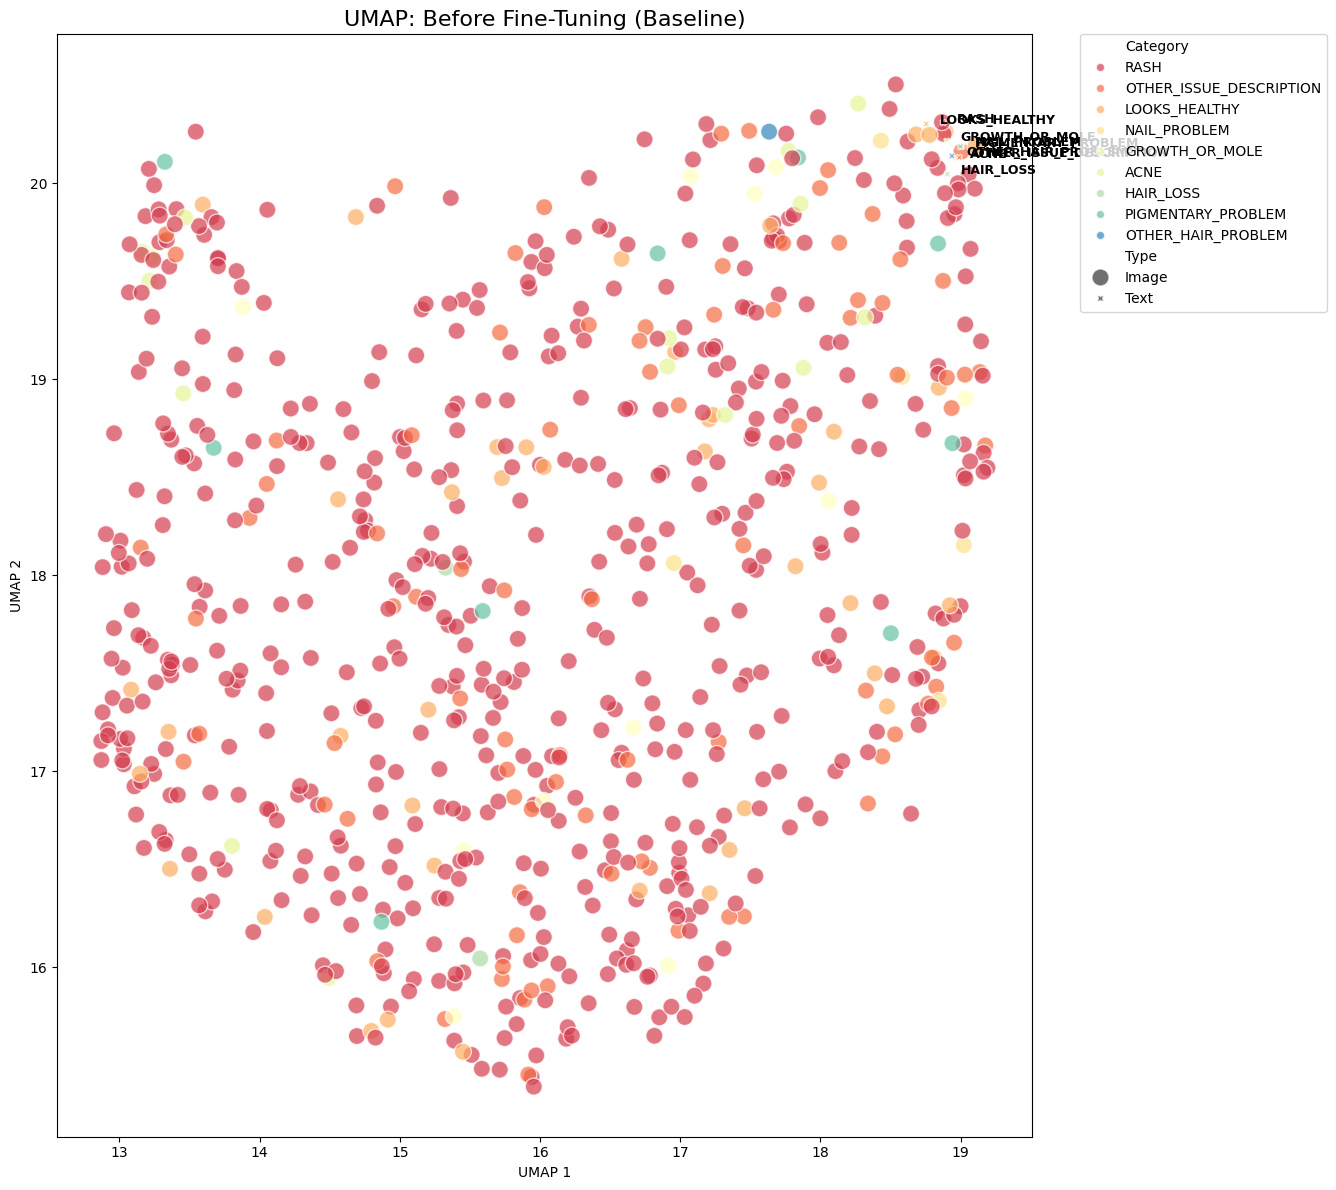


Generating UMAP for: UMAP: After Fine-Tuning


Getting Image Embeddings: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]
/home/vinoo/projects/health-kiosk/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP on 756 total embeddings...
UMAP plot saved to: ./siglip-scin-full-3000/umap_after_fine-tuning.png


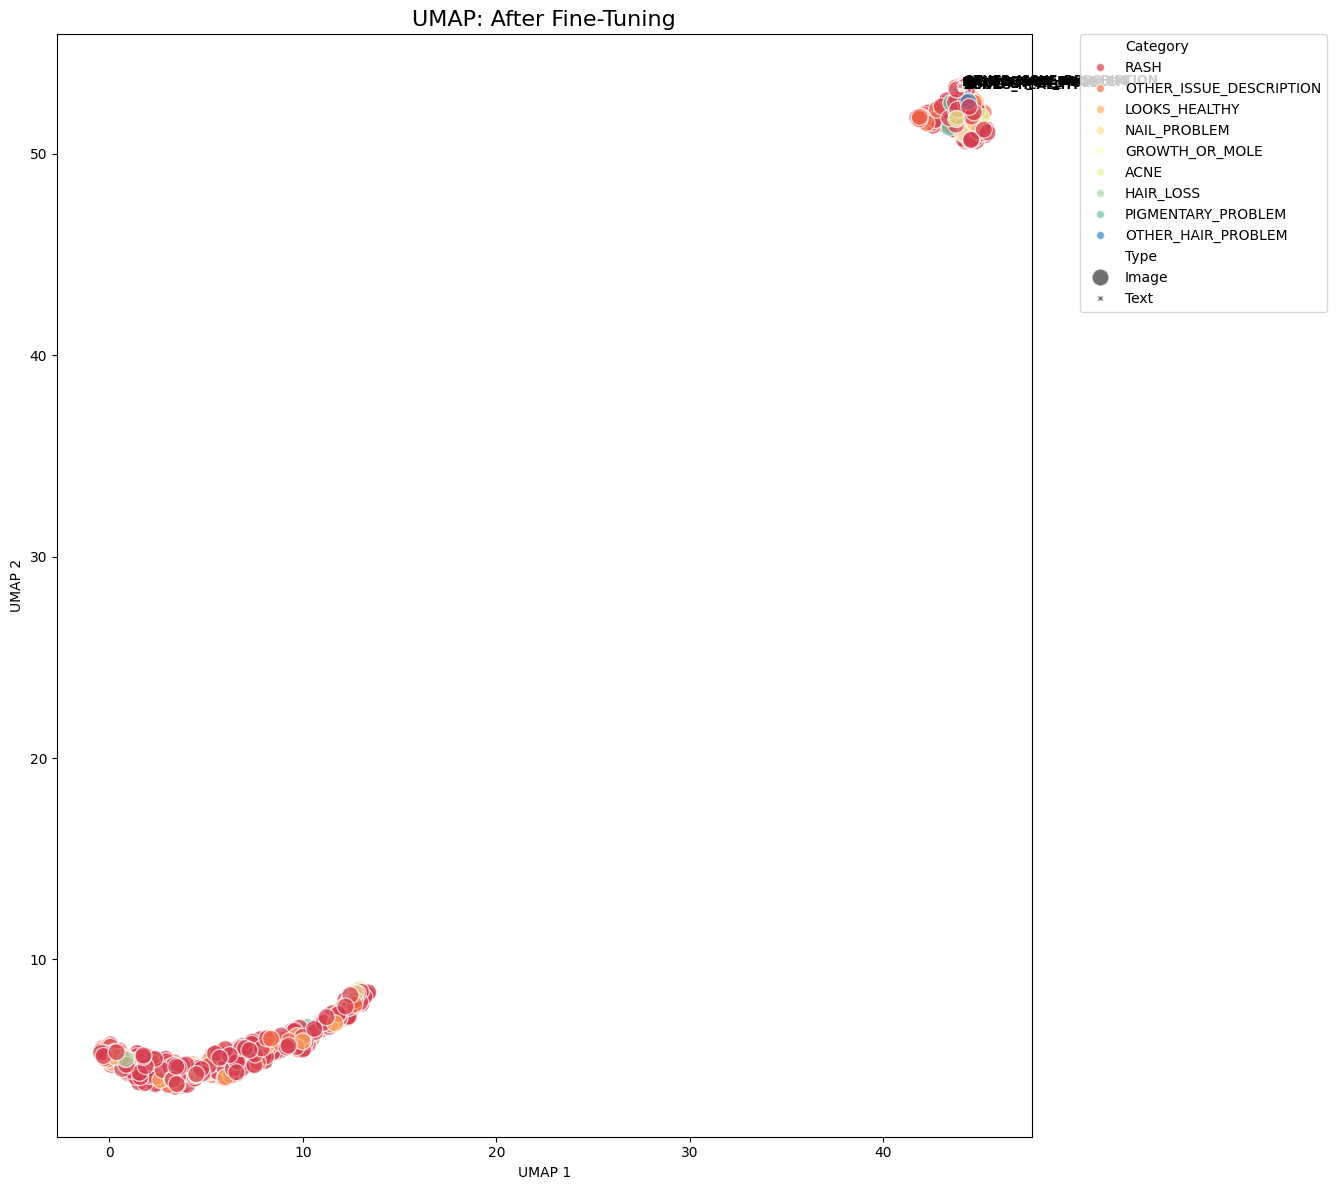

In [18]:
# Cell 17: Generate UMAP Plots

# Plot 1: Before training
plot_umap_embeddings(
    base_model,  # Use the original model
    val_dataset,
    processor,
    device,
    title="UMAP: Before Fine-Tuning (Baseline)"
)

# Plot 2: After training
plot_umap_embeddings(
    model_to_tune,  # Use the fine-tuned model
    val_dataset,
    processor,
    device,
    title="UMAP: After Fine-Tuning"
)